In [1]:
from config import *
from utilities.qcbm import ArbitraryRotation, CNOTEntangler, BlockQueue, QCBM
from utilities.kernels import RBFMMD2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.optimize import minimize
from scipy.stats import beta, entropy, wasserstein_distance

In [3]:
def get_nn_pairs(num_bit):
    '''get nearest neighbor pairs (CNOTs are applied to these pairs).'''
    res = []
    for inth in range(2):
        for i in range(inth, num_bit, 2):
            res = res + [(i, i_ % num_bit) for i_ in range(i + 1, i + 2)]
    return res

def get_circuit(num_bit, depth, pairs):
    '''Get the qcbm circuit with given number of qubits, depth and CNOT pairs'''
    blocks = []
    # build circuit
    for idepth in range(depth+1):
        blocks.append(ArbitraryRotation(num_bit))
        if idepth!=depth:
            blocks.append(CNOTEntangler(num_bit, pairs))
    # set leading and trailing Rz to disabled
    blocks[0].mask[::3] = False
    blocks[-1].mask[2::3] = False
    return BlockQueue(blocks)

In [4]:
def train(bm, theta_list, method, max_iter=1000, step_rate=0.1):
    '''
    train a Born Machine.

    Args:
        bm (QCBM): quantum circuit born machine training strategy.
        theta_list (1darray): initial parameters.
        method ('COBYLA'): optimization method
        max_iter (int): maximum allowed number of iterations.
        step_rate (float): learning rate for Adam optimizer.

    Returns:
        (float, 1darray): final loss and parameters.
    '''
    step = [0]
    def callback(x, *args, **kwargs):
        step[0] += 1
        print('step = %d, loss = %s'%(step[0], bm.mmd_loss(x)))

    theta_list = np.array(theta_list)
    res = minimize(bm.mmd_loss, x0=theta_list, method=method, tol=1e-12,
                   options={'maxiter': max_iter, 'disp': 0},callback=callback,)
    return res.fun, res.x

In [5]:
alpha = 2
beta_ = 2
m = 10
depth = 2
a = 0
b = 1

In [6]:
p_i_set = beta.pdf(np.linspace(a, b, 2**m), alpha, beta_)
p_i_set /= p_i_set.sum()

In [7]:
pairs = get_nn_pairs(m)
circuit = get_circuit(m, depth, pairs)
mmd = RBFMMD2(sigma_list=[1,2], basis=np.arange(2**m))
bm = QCBM(circuit, mmd, p_i_set, batch_size=None)

In [8]:
theta_list = np.random.random(bm.circuit.num_param)*2*np.pi
loss, theta_list = train(bm, theta_list, 'COBYLA', max_iter=99)
pl = bm.pdf(theta_list)

step = 1, loss = 0.0056933406280202
step = 2, loss = 0.00465727882004701
step = 3, loss = 0.004468855527804835
step = 4, loss = 0.00406294670537892
step = 5, loss = 0.004380269467006688
step = 6, loss = 0.00427601689188423
step = 7, loss = 0.004280738351529164
step = 8, loss = 0.004064078899727239
step = 9, loss = 0.004902865455229774
step = 10, loss = 0.004069636728418505
step = 11, loss = 0.004642804009245404
step = 12, loss = 0.004256728402013203
step = 13, loss = 0.004513207061700618
step = 14, loss = 0.004374426252638185
step = 15, loss = 0.004869143286263138
step = 16, loss = 0.004228516209491709
step = 17, loss = 0.003757887274257702
step = 18, loss = 0.003952127143158766
step = 19, loss = 0.00346179333700985
step = 20, loss = 0.0034394317169471706
step = 21, loss = 0.004378294969707079
step = 22, loss = 0.0039546566056106024
step = 23, loss = 0.003857382736565642
step = 24, loss = 0.003485537931651065
step = 25, loss = 0.004317304353539966
step = 26, loss = 0.003214867431496086

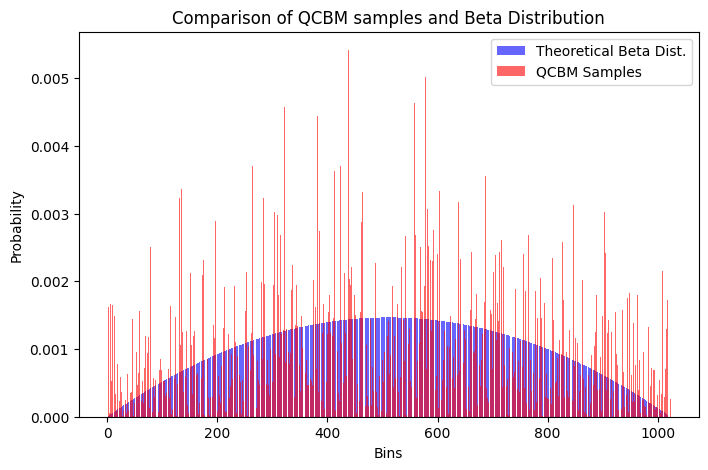

In [9]:
plt.figure(figsize=(8, 5))
plt.bar(range(len(p_i_set)), p_i_set, alpha=0.6, label='Theoretical Beta Dist.', color='blue')
plt.bar(range(len(pl)), pl, alpha=0.6, label='QCBM Samples', color='red')
plt.xlabel("Bins")
plt.ylabel("Probability")
plt.legend()
plt.title("Comparison of QCBM samples and Beta Distribution")
plt.show()

In [10]:
print("try:", p_i_set)

try: [0.00000000e+00 5.72763930e-06 1.14440699e-05 ... 1.14440699e-05
 5.72763930e-06 0.00000000e+00]


In [11]:
print("gen:", pl)

gen: [0.00079111 0.00034461 0.00162607 ... 0.00118002 0.00152637 0.00026889]


In [12]:
# griglia comune dei bin: è la stessa usata per costruire p_i_set
x = np.linspace(a, b, 2**m)  # [a,b] con 2^m bin

# Wasserstein corretta
emd = wasserstein_distance(x, x, u_weights=pl, v_weights=p_i_set)

l2 = np.sum((pl - p_i_set)**2)

cdf_gen = np.cumsum(pl)
cdf_target = np.cumsum(p_i_set)
ks = np.max(np.abs(cdf_gen - cdf_target))                  # Kolmogorov–Smirnov



print("try (target):", p_i_set)
print("gen (QCBM):", pl)
print(f"Earth Mover's Distance: {emd:.6e}")
print(f"L2: {l2:.6e}")
print(f"KS distance: {ks:.6e}")
print(f"final loss: {loss:.6e}")


try (target): [0.00000000e+00 5.72763930e-06 1.14440699e-05 ... 1.14440699e-05
 5.72763930e-06 0.00000000e+00]
gen (QCBM): [0.00079111 0.00034461 0.00162607 ... 0.00118002 0.00152637 0.00026889]
Earth Mover's Distance: 3.610312e-02
L2: 8.954982e-04
KS distance: 6.299425e-02
final loss: 1.839798e-03
